In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

 # PSF Sub and Halo Finding

The code in this notebook is to test and showcase written functions for the python environment 'pycube'. It is designed to analyze MUSE data containers and the surrounding halo around QSOs and neighboring supermassive black holes. 

## Imports and Data Reading

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sep
from photutils import EllipticalAperture
import scipy as sp
from PIL import Image

import pycube
from pycube.core import background
from pycube.core import manip
from pycube import msgs
from pycube import core
from pycube import cubeClass
from pycube import psf
from pycube import halos
from pycube.instruments import vlt_muse
from IPython import embed
import math
import gc

In [3]:
def convert_channel(datacontainer, value):
    
    data_headers = datacontainer.get_data_header()
    channel = (value - data_headers['CRVAL3']) / data_headers['CD3_3']
    
    return channel

There are three datasets that have been used for testing this program.

REQUIEM data with confirmed LYa halo

In [6]:
DATA_DIR = ('/home/ryan.foley/Downloads/P231COPY.fits')

--------------------

Initializes the class object 'test_cube' and initializes the data table by calling 'initialize_file'

In [7]:
test_cube = cubeClass.IfuCube(DATA_DIR, vlt_muse)

In [10]:
test_cube.get_headers()

(XTENSION= 'IMAGE   '           / IMAGE extension                                
 BITPIX  =                  -32 / number of bits per data pixel                  
 NAXIS   =                    3 / number of data axes                            
 NAXIS1  =                  374 / length of data axis 1                          
 NAXIS2  =                  353 / length of data axis 2                          
 NAXIS3  =                 1481 / length of data axis 3                          
 PCOUNT  =                    0 / required keyword; must = 0                     
 GCOUNT  =                    1 / required keyword; must = 1                     
 EXTNAME = 'DATA    '           / This extension contains data values            
 HDUCLASS= 'ESO     '           / class name (ESO format)                        
 HDUDOC  = 'DICD    '           / document with class description                
 HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
 HDUCLAS1= 'IMAG

In [8]:
test_cube.initialize_file()


This program is written with the assumption those using it know the RA and DEC of their object of interest. To recieve the coordinates in pixel value call the function object_coord from the manip module with your cube object, RA, DEC, and a search radius as arguments.

In [9]:
# for P231
x_pos, y_pos = manip.object_coord(test_cube, 231.65765, -20.83354, 4)

Known red shift value for P231 and the assumed general velocity for LyA emission

In [8]:
z = 6.5864 # red shift value of P231

lyA = 1215.67 #angstroms
c = 299792.458 # km/s
lyaDefault = 1000 # km/s
lyaLine = (1+z) * lyA

# Data Manipulation

The code is designed for users to specify how much of the container they want to analyze and on which axis they want to collapse upon. Given these are large data sets, analysis of a smaller section can be beneficial for hardware restraints. 

## Viewing Data

We can view the fits table which gives us the header descriptions of values and constants in the data as well as dimensions for our data container. For MUSE data we have a data set and 'stat' set, which is an equally sized variance cube of our data. 

In [9]:
test_cube.hdul.info()


Filename: /home/ryan.foley/Downloads/P231COPY.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1355   ()      
  1  DATA          1 ImageHDU        51   (374, 353, 1481)   float32   
  2  STAT          1 ImageHDU        43   (374, 353, 1481)   float32   


The primary row contains just header information but is beneficial when working with this data. Below is the output.

In [10]:
test_cube.hdul[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  374 / length of data axis 1                          
NAXIS2  =                  353 / length of data axis 2                          
NAXIS3  =                 1481 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

## Cube Collapsing 

Here we can collapse along a range of wavelength values, which is our z-axis, to produce a flattened section of the cube. Below are operations to collapse the first 300 wavelengths and display the 2D image.

In [11]:
collapsed_300D, collapsed_300S = manip.collapse_container(test_cube, 0, 300)


In [12]:
np.shape(collapsed_300D)

(353, 374)

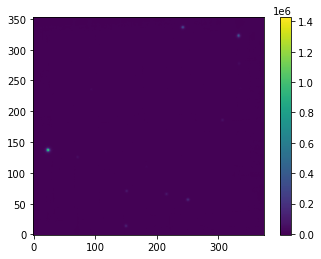

In [13]:
plt.imshow(collapsed_300D, origin = 'lower')
plt.colorbar()

Alternatively, we could not specify a range and the function will collapse the entire container.

In [14]:
collapsed_fullD, collapsed_fullS = manip.collapse_container(test_cube)


collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 1481
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0


In [15]:
np.shape(collapsed_fullD)

(353, 374)

30

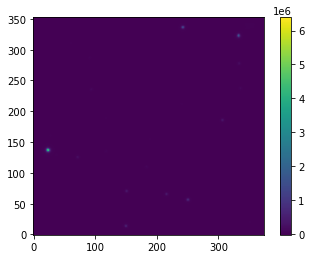

In [16]:
plt.imshow(collapsed_fullD, origin = 'lower')
plt.colorbar()
gc.collect()

## De-reddening

There is an added function to correct for de-reddening of the data from cosmic dust. This function converts the entire data container which can then be re-collapsed and analyzed. Our code currently uses the extinction package with a model of Fitzpatrick & Massa (2007)

In [17]:
deRed_fullD, deRed_fullS = manip.dust_correction(test_cube)

DO NOT USE THIS


In [18]:
deRed_collapse = manip.collapse_cube(deRed_fullD)

collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 1481
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0


In [19]:
np.shape(deRed_collapse)

(353, 374)

5619

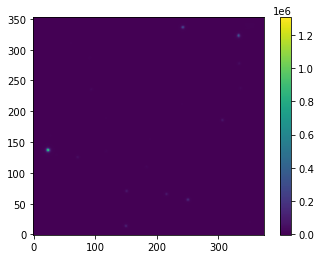

In [20]:
plt.imshow(deRed_collapse, origin = 'lower')
plt.colorbar()

gc.collect()

# Background and Sources

## Background Sub

First we want to remove any residual sources in the background.

subtract_bg is a function which utilizes SEP to smooth the background after isolating the sources. SEP is a re-creation of SourceXtractor for Python. These functions and beyond have parameters that must be tuned for each data set. We read in our object for some functions, where as others require output from earlier functions. 

subtract_bg: Starting the procedure to subtract the background
stat_bg: Searching for sources in the collapsed cube
collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 1481
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 1481
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Detected 44 sources
stat_bg: Masking Edges
stat_bg: Masking sources
stat_bg: Performing b/g statistic
stat_bg: Saving debug image on /home/ryan.foley/Downloads/P231COPY.fits_BgRegion.pdf


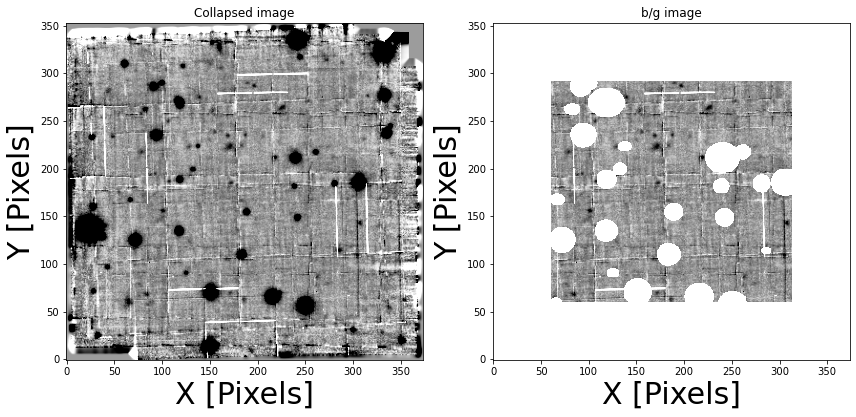

subtract_bg: Subtracting background from datacube
subtract_bg: Estimating correction for statcube variance
subtract_bg: The average correction factor for variance is 0.99945
DO NOT USE THIS


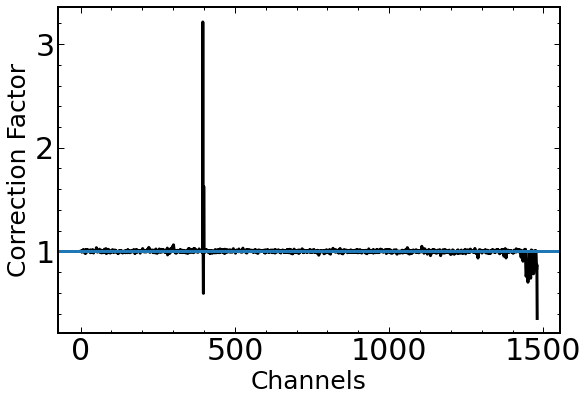

subtract_bg: The average value subtracted to the b/g level is 0.03503
DO NOT USE THIS


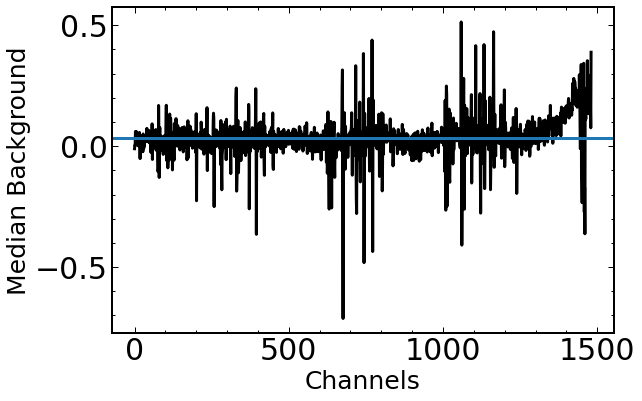

0

In [21]:
dataBg, statBg, averageBg, medianBg, stdBg, varBg, pixelsBg, maskBg2D = psf.subtract_bg(test_cube,
                                                                        sig_source_detect = 0.05,
                                                                        min_source_area=2.,
                                                                        source_mask_size=7.,
                                                                        edges=60,
                                                                        output = DATA_DIR,
                                                                        debug = True,
                                                                        show_debug = True,
                                                                        sigma_clipping = False)
gc.collect()
gc.collect()

## Writing to File

Here we have a function which performs the above tasks of background isolation and source masking. It iterates through the entire cube, and writes the background and masks to the file. These code blocks are not active but are here to represent the availability of this function with the package.

test_cube.get_background()

test_cube.hdul.writeto('writetotest.fits',output_verify = 'silentfix', overwrite = True,checksum = True)

test_cube.hdul.info()

Below it shows the now updated .fits with added rows for 'MASK' and 'BACKGROUND'.

We can showcase an example of the new sections by slicing a single wavelength and plotting the image. 

plt.imshow(test_cube.hdul[4].data[120,:,:], origin = 'lower')
plt.title('Example of BACKGROUND',size = 18)
plt.colorbar()

plt.imshow(test_cube.hdul[3].data[120,:,:], origin = 'lower')
plt.title('Example of MASK', size = 18)
plt.colorbar()

# Wavelengths

## Atmosphere 

We can also convert our channel values into wave lengths using the 'convert_to_wave' function from the manip module.
This function is utilized in other functions as well, but it stands on it's own for usability.

In [22]:
wavearray = manip.convert_to_wave(test_cube,test_cube.get_data())

DO NOT USE THIS


Ploting the subtracted background average, median and sigma with the wave lengths yields the plot below. Notice that sigma is our atmospheric background.

7953

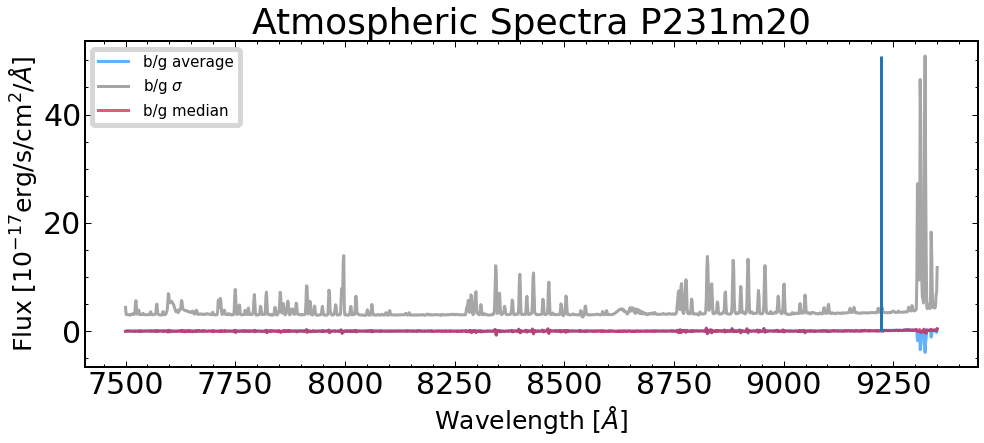

In [24]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray, averageBg, alpha=0.7, color='dodgerblue', label='b/g average')
plt.plot(wavearray, stdBg, alpha=0.7, color='grey', label='b/g $\sigma$')
plt.plot(wavearray, medianBg, alpha=0.7, color='crimson', label='b/g median')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.legend(prop={"size": 15})
plt.title('Atmospheric Spectra P231m20')
gc.collect()

## Quasar Spectrum

Using the function 'q_spectrum' from the manip module, we can extract the spectra from the object of interest. This function assumes the RA and DEC of the object have been converted to pixel values.

In [25]:
fluxQso, errQso, bgQso = manip.q_spectrum(test_cube,x_pos,y_pos)


We can plot the the data wavelengths against this flux 

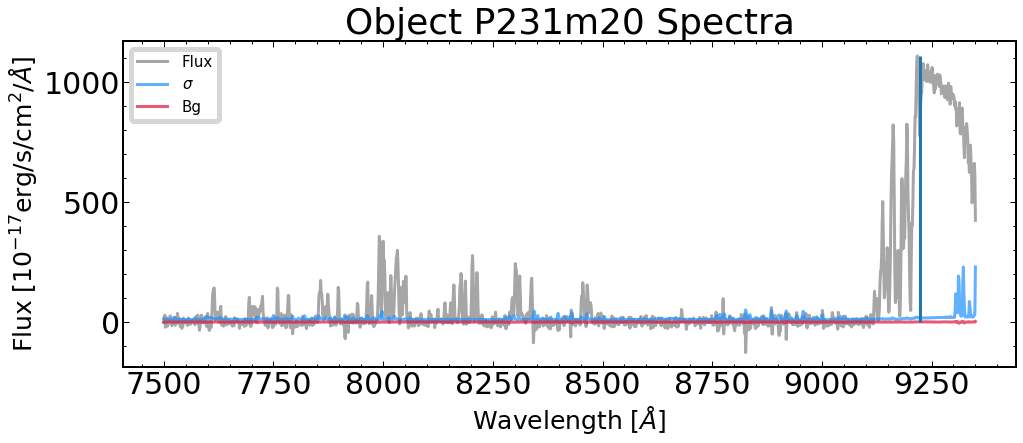

In [26]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(wavearray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(wavearray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('Object P231m20 Spectra')
plt.vlines(x=lyaLine,ymin=0,ymax=max(fluxQso))
plt.legend(prop={'size': 15})

------------------

Another helpful function is to call .get_dimensions on the IFUcube object to quickly get its value ranges. Specifically, this is helpful to see the channel ranges of the previous plot.

In [27]:
z_max, y_max, x_max = test_cube.get_dimensions()
channelarray = np.arange(0,z_max, 1)

6125

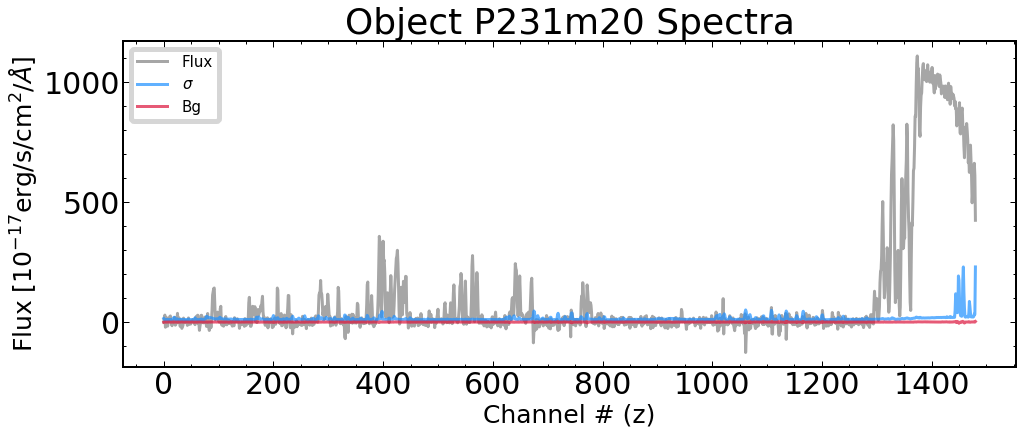

In [30]:
plt.figure(0, figsize=(16,6))
plt.plot(channelarray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(channelarray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(channelarray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Channel # (z)')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('Object P231m20 Spectra')
plt.legend(prop={'size': 15})
gc.collect()

 From this plot, we can easily visualize the channel values where we need to cut off / shrink the cube to perform the following functions in the package.

 ----------------

# Condensing Data

Now that we can easily visualize our data set we can subsection to the portion we believe to find our Lyman-Alpha halo. 

## Reshaping

In [31]:
minz = int(lyaLine - 200)
maxz = int(lyaLine + 200)

In [32]:
small_testcube = manip.small_IFU(test_cube, DATA_DIR, minz,maxz)

small_cube: Converting min wavelength in Ang. to channel number
small_cube: Converting Max wavelength in Ang. to channel number
small_cube: max_lambda is outside the cube size. Set to 1481
small_cube: Creating smaller cube
           The old pivot wavelength was 7500.0
           The new pivot wavelength is 9021.25


We have now created a smaller cube with the absorbed spectra removed. This will cut down on computation time as well as allowing us to work with isolated and precise spectra.

## New BG sub

subtract_bg: Starting the procedure to subtract the background
stat_bg: Searching for sources in the collapsed cube
collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 264
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 264
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Detected 26 sources
stat_bg: Masking Edges
stat_bg: Masking sources
stat_bg: Performing b/g statistic
stat_bg: Saving debug image on /home/ryan.foley/Downloads/P231COPY.fits_BgRegion.pdf


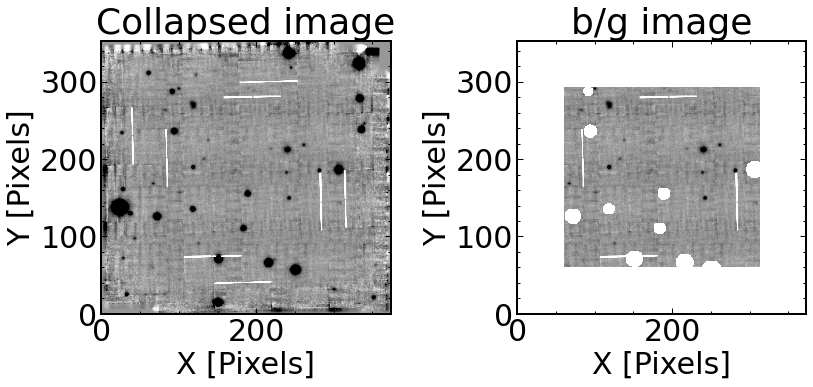

subtract_bg: Subtracting background from datacube
subtract_bg: Estimating correction for statcube variance
subtract_bg: The average correction factor for variance is 0.99009
DO NOT USE THIS


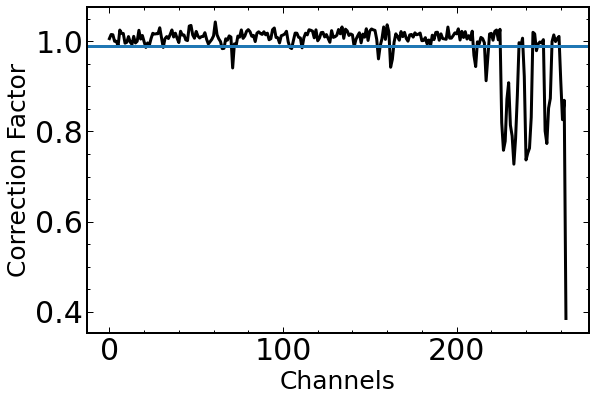

subtract_bg: The average value subtracted to the b/g level is 0.11835
DO NOT USE THIS


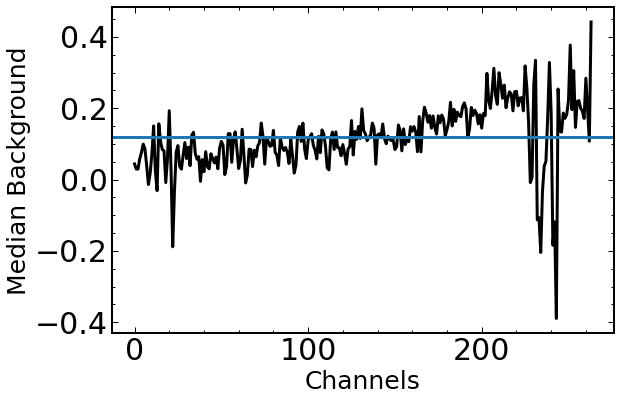

In [33]:
dataBg, statBg,averageBg, medianBg, stdBg, varBg, pixelsBg, maskBg2D = psf.subtract_bg(small_testcube,
                                                                                       sig_source_detect=0.2,
                                                                                       min_source_area=1,
                                                                                       source_mask_size=7,
                                                                                       edges=60,
                                                                                       output=DATA_DIR,
                                                                                       debug=True,
                                                                                       show_debug=True,
                                                                                       sigma_clipping=False)

## New Flux plot

In [34]:
fluxQso, errQso, bgQso = manip.q_spectrum(small_testcube,x_pos,y_pos)
gc.collect()

0

In [59]:
newlyaLine = int(convert_channel(small_testcube,lyaLine))
newlyaLine

161

In [36]:
z_max, y_max, x_max = small_testcube.get_dimensions()
channelarray = np.arange(0,z_max, 1)

15

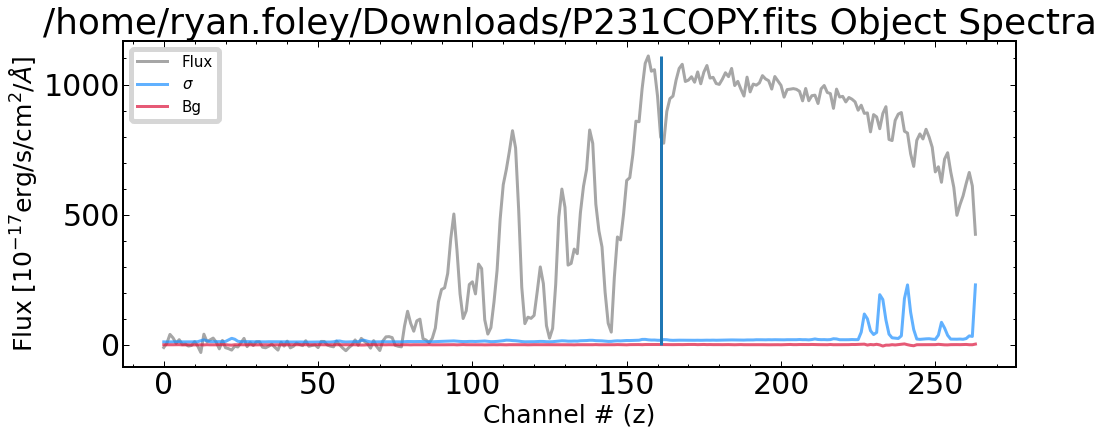

In [37]:
plt.figure(0, figsize=(16,6))
plt.plot(channelarray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(channelarray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(channelarray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Channel # (z)')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('{} Object Spectra'.format(DATA_DIR))
plt.vlines(x=newlyaLine,ymin=0,ymax=max(fluxQso))
plt.legend(prop={'size': 15}, loc="upper left")
gc.collect()

# Point Spread Function

The following code impliments a point-spread function to remove the highly luminous QSO (or other source) to isolate the potential surround halo.

## PSF Creation

The first step is to normalize the flux produced by the QSO. using c_type=sum does just this. We also need to perform this function along the continuum just beyond were we estimate our LYa emission to be.

In [61]:
min_lambda = newlyaLine + 50
max_lambda = newlyaLine + 100

create_psf: Creating PSF model
create_psf: Summing channels
quick_ap_photometry: Performing aperture photometry
Source 1 : Aperture photometry on source at: 189.17589014001533, 155.13206923452233
create_psf: Removing local background of [9.27662706]
create_psf: Normalizing central region to 1
         (i.e. correcting for a factor [41032.65511632]
create_psf: Creating circular mask around the position 189.17589014001533, 155.13206923452233
location: single source identified
create_psf: Creating debug images
DO NOT USE THIS


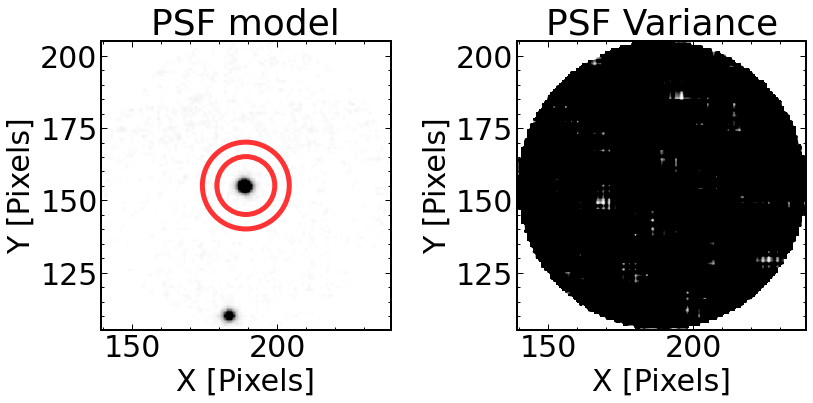

0

In [62]:
psf_data, psf_stat = psf.create_psf(dataBg,statcube=statBg,x_pos=x_pos,y_pos=y_pos,
                                    inner_rad=20,outer_rad=30,
                                    min_lambda=min_lambda,max_lambda=max_lambda,
                                    debug = True,show_debug=True, c_type = 'sum')
gc.collect()
gc.collect()

-------------

## PSF Cleaning

The function 'clean_psf' from the fitting psf module takes the now normalized psf model and subtracts the contribution.

clean_psf: PSF subtraction on cube
clean_psf: The min, max values for PSF model are: -0.0053, 0.1357
clean_psf: Spectrum of the source
DO NOT USE THIS


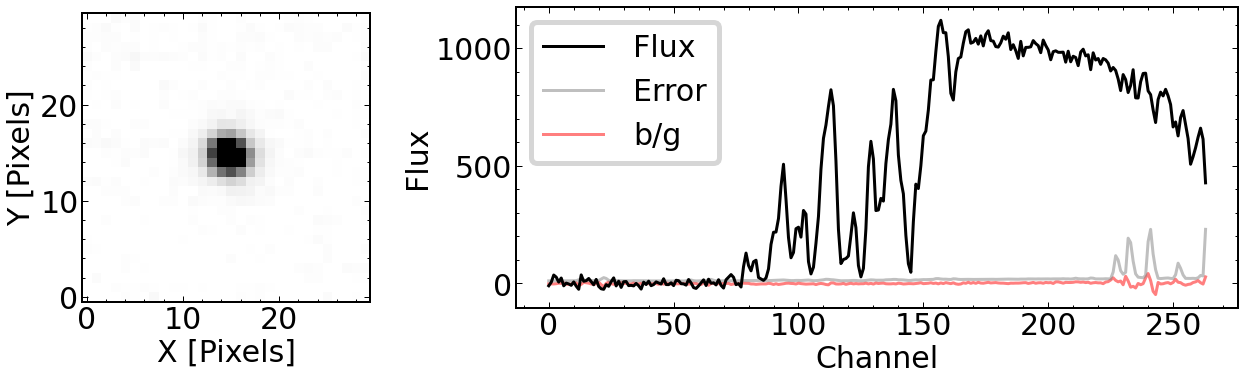

clean_psf: PSF cleaning performed


0

In [63]:
dataCubeClean, dataCubeModel = psf.clean_psf(small_testcube,
                                             psf_model=psf_data,
                                             x_pos=x_pos,y_pos=y_pos,
                                             debug=True,radius_pos=2.,
                                             inner_rad=15.,outer_rad = 25.,
                                             show_debug = True) 
gc.collect()
gc.collect()

# Halo Finding

To preserve memory and remain accurate, we use two parameters here to smooth our data. These are the background corrected data and variance cubes. The function 'smooth_chicube' smooths the cube in the spatial (a_smooth) and spectral (v_smooth) axes.

We use the above plots to set our shrinking parameters min and max lambda.

## Cube Smoothing

First we calculate where we expect to find a LyA halo from the original sized data cube parameters. Then we convert these wavelengths and and using an estimated velocity we find a range of values to search within the shrunken data cube.

In [83]:
min_halo_norm = lyaLine * (1. - (lyaDefault/c))
max_halo_norm = lyaLine * (1. + (lyaDefault/c))

In [84]:
min_halo = int(convert_channel(small_testcube, min_halo_norm))
max_halo = int(convert_channel(small_testcube, max_halo_norm))

In [85]:
chiCube, sChiCube = halos.smooth_chicube(dataCubeClean,statcube=statBg,
                                         min_lambda=int(min_halo),
                                         max_lambda=int(max_halo),
                                         s_smooth=1,
                                         v_smooth=2)
shape = np.shape(sChiCube)

z_position = int(shape[0] / 2) # finds middle datapoint in wavelength range for creating the halo mask

smooth_chicube: Shrinking cube with given parameters
smooth_chicube: Smoothing cube with 3D Gaussian Kernel


----------------

## Halo Mask

halo_mask is the crucial function to the halo finding module. This function performs a friend of friend algorith from a high value voxel nearby the source on the now smoothed and background corrected cube. 

halo_mask: removing inner region around (x,y)=(189.18,155.13)
          with radius 1 pixels
location: single source identified
halo_mask: removing outer region around (x,y)=(189.18,155.13)
          with radius 40 pixels
location: single source identified
halo_mask: defining threshold level
stat_fullcube: statistic on the cube
stat_fullcube: average = +0.082
              median  = +0.072
              sigma   = +0.230
stat_fullcube_z: statistic on the cube
halo_mask: the median value of the voxels is: +0.0725
          and the sigma is: +0.2301
halo_mask: the average relative threshold value set to 2.00*0.2301=0.4601
halo_mask: Saving debug image on /home/ryan.foley/Downloads/P231COPY.fits_voxelDistribution.pdf
          in principle the distribution should be gaussian
          showing only channel 24
DO NOT USE THIS


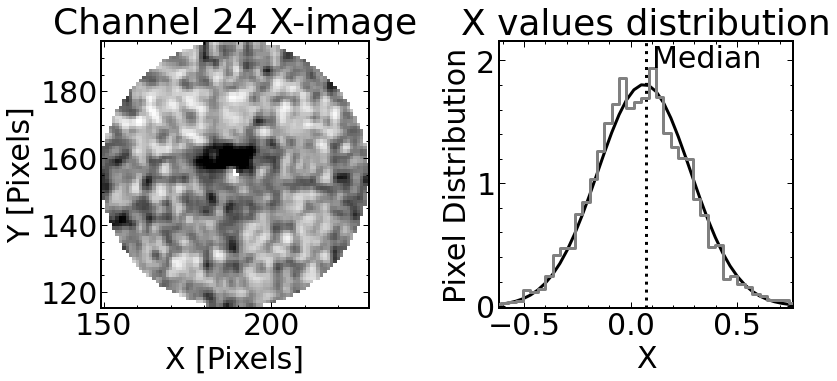

halo_mask: searching for extended emission
          starting from from (x,y,z)=(189.18,155.132,24)
halo_mask: the maximum S/N detected is 0.857 
          at the location (x,y,z)=(191,157,23)
halo_mask: starting to fill the halo mask
halo_mask: Creating debug image
          Plotting channel 23 where the most significant voxel is.
          The location of this voxel is marked with a red circle
          The position of the quasar is in blue
spectral_mask_halo: collapsing halo mask
halo_mask: debug image saved in /home/ryan.foley/Downloads/P231COPY.fits_maskHaloStartingVoxel.pdf


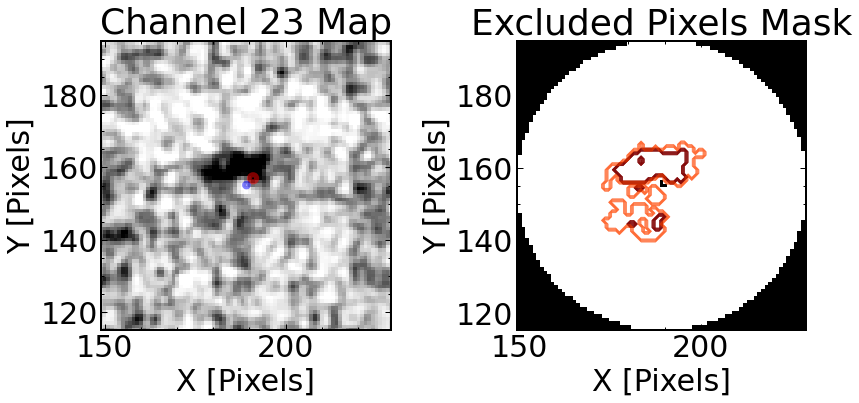

0

In [87]:
maskHalo = halos.halo_mask(sChiCube,
                           x_pos=x_pos,
                           y_pos=y_pos,
                           z_pos=z_position,
                           rad_bad_pix=1,
                           rad_max=40,
                           r_connect=2,
                           threshold=2,
                           threshold_type='relative',
                           bad_pixel_mask=None,
                           output=DATA_DIR,
                           debug=True,
                           show_debug=True)
gc.collect()
gc.collect()

mask_halo_cleaned: cleaning halo mask
mask_halo_cleaned: Removed 5031.0 voxels from the mask
spectral_mask_halo: collapsing halo mask
spectral_mask_halo: collapsing halo mask
spectral_mask_halo: not enough voxels in the mask


/home/ryan.foley/PycharmProjects/pycube/pycube/halos.py:577: UserWarning: No contour levels were found within the data range.
  plt.contour(clean_mask_2D, colors='red',


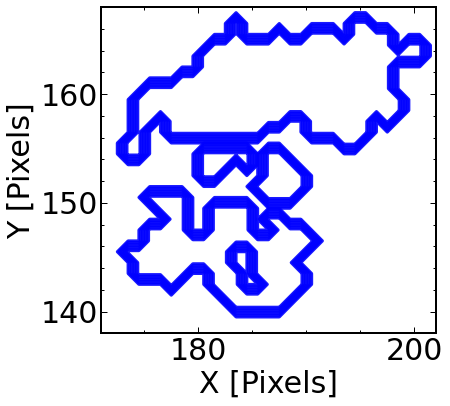

In [88]:
clean_halo = halos.clean_mask_halo(maskHalo,
                                    delta_z_min=1,
                                    min_vox=300,
                                    min_channel=int(min_halo),
                                    max_channel=int(max_halo),
                                    debug=True,
                                    show_debug=True)

In [89]:
halo_mask_2D, min_halo, max_halo = halos.spectral_mask_halo(clean_halo)

spectral_mask_halo: collapsing halo mask
spectral_mask_halo: not enough voxels in the mask


mask_halo_cleaned: cleaning halo mask
mask_halo_cleaned: Removed 16.0 voxels from the mask
spectral_mask_halo: collapsing halo mask
spectral_mask_halo: collapsing halo mask


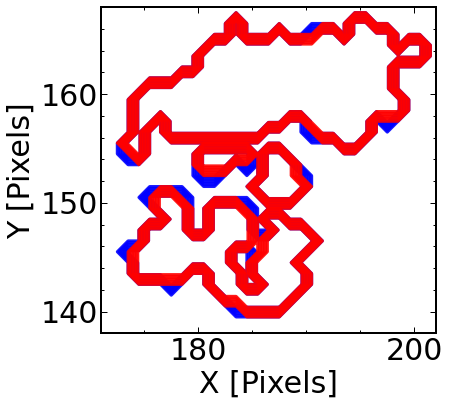

In [90]:
clean_halo = halos.clean_mask_halo(maskHalo,
                                    delta_z_min=1,
                                    min_vox=300,
                                    min_channel=int(min_halo),
                                    max_channel=int(max_halo),
                                    debug=True,
                                    show_debug=True)

make_moments: estimating halo moments
make_moments: masking 11405 NaNs with a 2 spatial pixel Gaussian Kernel
             the total number of voxels is 6469078
make_moments: smoothing cube
spectral_mask_halo: collapsing halo mask
q_spectrum_no_bg_mask: Extracting spectrum from the cube
q_spectrum_no_bg_mask: Extracting spectrum from the cube
make_moments: the central wavelength considered is +9061.72
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 49
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0


/home/ryan.foley/PycharmProjects/pycube/pycube/core/manip.py:1054: RuntimeWarning: invalid value encountered in sqrt
  err_flux_obj = np.sqrt(np.nansum(statcopy, axis=(1, 2)))
/home/ryan.foley/PycharmProjects/pycube/pycube/halos.py:734: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_shift_cube * tmp_datacopy, axis=0) / np.nansum(tmp_datacopy, axis=0)
/home/ryan.foley/PycharmProjects/pycube/pycube/halos.py:740: RuntimeWarning: invalid value encountered in true_divide
  mom2 = np.sqrt(np.nansum(sigma_cube * tmp_datacopy, axis=0) / np.nansum(tmp_datacopy, axis=0))
/home/ryan.foley/PycharmProjects/pycube/pycube/halos.py:740: RuntimeWarning: invalid value encountered in sqrt
  mom2 = np.sqrt(np.nansum(sigma_cube * tmp_datacopy, axis=0) / np.nansum(tmp_datacopy, axis=0))


make_moments: showing debug image:
             spectrum and optimally extracted spectrum


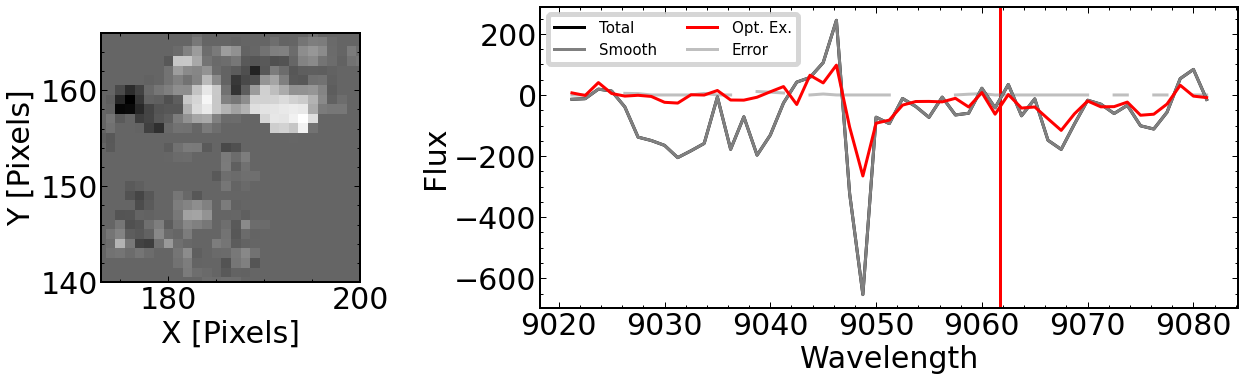

make_moments: showing debug image:
             0, 1, and 2 moments


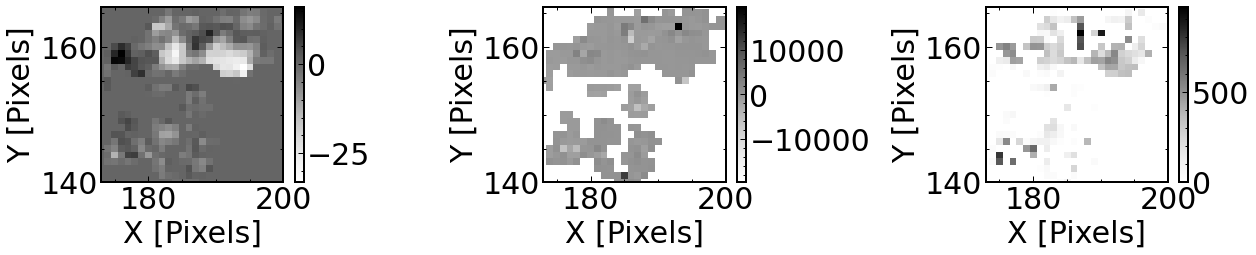

In [91]:
mom0, mom1, mom2, cen_wave = halos.make_moments(small_testcube, dataCubeClean[min_halo:max_halo, :, :],
                                                dataCubeModel[min_halo:max_halo, :, :],
                                                clean_halo[min_halo:max_halo, :, :], s_smooth=1,
                                                debug=True, show_debug=True)